In [1]:
%matplotlib inline

import matplotlib
import autograd.numpy as np
import matplotlib.pyplot as plt
import random
import math
from autograd import grad

def generateChevronData():
    xBounds = [-50, 50]
    yBounds = [-50, 50]
    totalPoints = 100
    
    points = []
    targets = []
    
    for i in range(0, totalPoints):
        x = random.randint(xBounds[0], xBounds[1])
        y = random.randint(yBounds[0], yBounds[1])
        
        if x >= y and x <= -y:
            points.append([1, x/50.0,y/50.0])
            targets.append(0)
        else:
            points.append([1, x/50.0,y/50.0])
            targets.append(1)
        
    return np.array(points), np.array(targets)
    
def plotScatter(points):
    xs = [x[1] for x in points]
    ys = [y[2] for y in points]
    
    plt.scatter(xs, ys)

In [8]:
def sigmoid(phi):
    return 1.0/(1.0 + np.exp(-phi))

def MSE(weights):
    predictions = logisticPrediction(weights, points)
    w = np.full((len(predictions)), np.log(1/2))
    r = np.full((len(predictions)), 1.0)
    return -np.sum( r * ((targets*np.log(predictions) + (1-targets)*np.log(1-predictions))) + (1-r) * w)

def logisticPrediction(weights, p):
    return np.array(list(map(lambda x: predict(weights, x), p))) 
    
def predict(weights, inputs):
    n = np.array([weights[0], weights[1]])
    i = np.array([weights[2] - inputs[1], weights[3] - inputs[2]])
#     n = np.array([weights[0], weights[1] - weights[3], weights[2] - weights[4]])
    return sigmoid(np.dot(n, i))

In [9]:
def computeGradient(weights, example, target):
    prediction = predict(weights, example)
    dE_dO = computeErrorDifferential(prediction, target)
    
    dO_dZ = prediction * (1-prediction)
    
#     dZ_d0 = example[0]
    dZ_d1 = (weights[2] - example[1])
    dZ_d2 = (weights[3] - example[2])
    dZ_d3 = weights[0]
    dZ_d4 = weights[1]
    
    dE_dZ = dE_dO * dO_dZ
    
    grad = np.zeros(len(weights))#[0.0, 0.0, 0.0]
#     grad[0] = dZ_d0 * dE_dZ
    grad[0] = dZ_d1 * dE_dZ
    grad[1] = dZ_d2 * dE_dZ
    grad[2] = dZ_d3 * dE_dZ
    grad[3] = dZ_d4 * dE_dZ
    
    return grad

def computeErrorDifferential(prediction, target):
    return -(target - prediction)/(prediction - prediction**2)

In [10]:
def trainBoundaryHunter():
    weights = np.array([0.0, 0.0, 0.0, 0.0])
    
    print("Initial Loss: ", MSE(weights))
    for i in range(0, 10000):
        weights = computeStep(weights)
    
        if i % 1000 == 0:
            print("Loss [i = " + str(i) + "]: " + str(MSE(weights)))
            print(weights)
            
    print("Trained Loss: ", MSE(weights))    
    print("Weights: ", weights)
    return weights

def computeStep(weights):
    totalG = np.zeros(len(weights))
    totalE = 0
    for i in range(0, len(points)):
        g = computeGradient(weights, points[i], targets[i])
        totalG += g     
        
#     totalG = totalG * (1/len(points))
    
    weights -= totalG * 0.001
    return weights

Type 0:  35
Type 1:  65
Initial Loss:  69.314718056

Loss Before: 69.314718056
Loss After [i = 0]: 68.9889247372
[-0.00158 -0.01802  0.       0.     ]

Loss Before: 27.3676190864
Loss After [i = 1000]: 27.3655550506
[-0.91881008 -4.55299621 -0.04493059 -0.43901215]

Loss Before: 26.479698099
Loss After [i = 2000]: 26.4793681755
[-1.19177789 -5.42107261 -0.0437357  -0.43332278]

Loss Before: 26.3036472808
Loss After [i = 3000]: 26.303563446
[-1.32084335 -5.81169791 -0.04336549 -0.43166597]

Loss Before: 26.2551857675
Loss After [i = 4000]: 26.2551604312
[-1.38979369 -6.01727926 -0.04319824 -0.43093591]

Loss Before: 26.2399707886
Loss After [i = 5000]: 26.2399624698
[-1.42872043 -6.13262677 -0.04311132 -0.43056119]

Loss Before: 26.2348731253
Loss After [i = 6000]: 26.234870271
[-1.45133644 -6.199439   -0.04306303 -0.43035443]

Loss Before: 26.2331040393
Loss After [i = 7000]: 26.2331030354
[-1.46468633 -6.23881282 -0.04303524 -0.4302359 ]

Loss Before: 26.2324777248
Loss After [i = 800

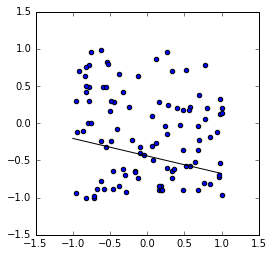

In [11]:
random.seed(1234)
points, targets = generateChevronData()

plt.axis([-1.5, 1.5, -1.5, 1.5])

# Plot points on graph
c1 = []
c2 = []

for i in range(0, len(points)):
    if targets[i] == 0:
        c1.append(points[i])
    else:
        c2.append(points[i])

print("Type 0: ", len(c1))
print("Type 1: ", len(c2))
        
plotScatter(c1)
plotScatter(c2)

weights = trainBoundaryHunter()

# plt.scatter(weights[1], weights[2])
plt.scatter(weights[2], weights[3])

n = np.array([weights[0] * weights[2] + weights[1] * weights[3], 
              -weights[0], 
              -weights[1]])

byas = -1 * n[0]/n[2]
Xcoef = -1 * n[1]/n[2]

# print()
# print(n)
# print("\nLine")
# print("B: " + str(byas))
# print("XCoef: " + str(Xcoef))

plt.plot([-1.0, 1.0], [-1*Xcoef + byas, Xcoef + byas], 'k-')
plt.gca().set_aspect('equal')

plt.show()